In [1]:
import mxnet as mx

/home/poodar/Library/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
c = a + b
(a, b, c)

(<Symbol a>, <Symbol b>, <Symbol _plus0>)

In [3]:
d = a * b
e = mx.sym.dot(a, b)
f = mx.sym.reshape(d+e, shape=(1, 4))
g = mx.sym.broadcast_to(f, shape=(2, 4))

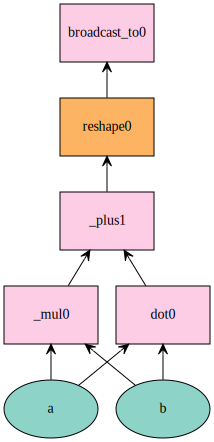

In [4]:
mx.viz.plot_network(symbol=g)

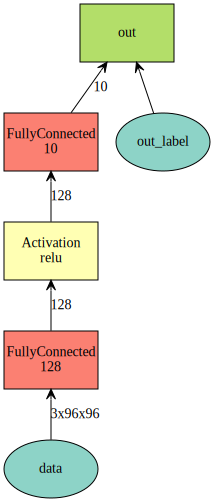

In [5]:
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type='relu')
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=10)
net = mx.sym.Softmax(data=net, name='out')
mx.viz.plot_network(net, shape={'data':(100, 3, 96, 96)})

In [6]:
net.list_arguments()

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'out_label']

In [7]:
net = mx.sym.Variable('data')
w = mx.symbol.Variable('myweight')
net = mx.symbol.FullyConnected(data=net, weight=w, name='fc1', num_hidden=128)
net.list_arguments()

['data', 'myweight', 'fc1_bias']

In [9]:
lhs = mx.symbol.Variable('data1')
rhs = mx.symbol.Variable('data2')
net = mx.symbol.FullyConnected(data=lhs + rhs, name='fc1', num_hidden=128)
net.list_arguments()

['data1', 'data2', 'fc1_weight', 'fc1_bias']

In [10]:
data = mx.symbol.Variable('data')
net1 = mx.symbol.FullyConnected(data=data, name='fc1', num_hidden=10)
net1.list_arguments()
net2 = mx.symbol.Variable('data2')
net2 = mx.symbol.FullyConnected(data=net2, name='fc2', num_hidden=10)
composed = net2(data2=net1, name='composed')
composed.list_arguments()

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias']

In [14]:
data = mx.sym.Variable('data3')
net = data
n_layer = 2
for i in range(n_layer):
    with mx.name.Prefix('layer%d_' %(i+1)):
        net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=100)
net.list_arguments()

['data3',
 'layer1_fc1_weight',
 'layer1_fc1_bias',
 'layer2_fc1_weight',
 'layer2_fc1_bias']

In [15]:
def ConvFactory(data, num_filter, kernel, stride=(1, 1), pad=(0, 0), name=None, suffix=''):
    conv = mx.sym.Convolution(data=data, num_filter=num_filter, kernel=kernel, stride=stride, pad=pad, \
                             name='conv_%s%s' %(name, suffix))
    bn = mx.sym.BatchNorm(data=conv, name='bn_%s%s' %(name, suffix))
    act = mx.sym.Activation(data=bn, act_type='relu', name='relu_%s%s' %(name, suffix))

    return act

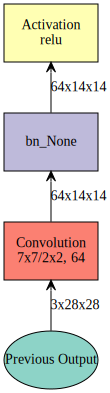

In [17]:
prev = mx.sym.Variable('Previous Output')
conv_comp = ConvFactory(data=prev, num_filter=64, kernel=(7, 7), stride=(2, 2), pad=(3, 3))
shape = {"Previous Output" : (128, 3, 28, 28)}
mx.viz.plot_network(symbol=conv_comp, shape=shape)

In [18]:
# Then we can define a function that construct an inception module based on factory function ConvFactory

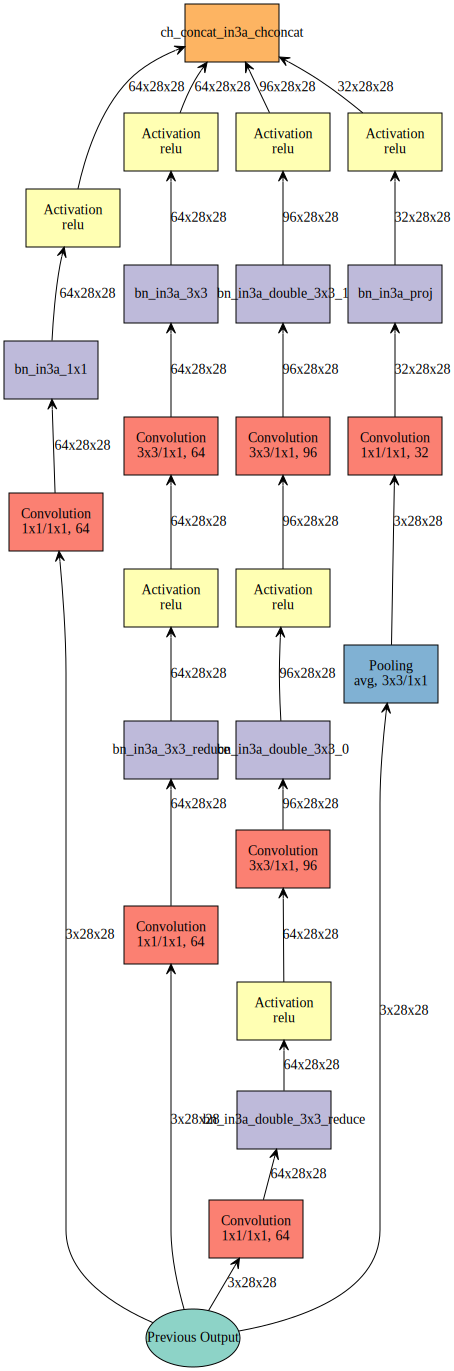

In [29]:
def InceptionFactoryA(data, num_1x1, num_3x3red, num_3x3, num_d3x3red, num_d3x3,
                      pool, proj, name):
    # 1x1
    c1x1 = ConvFactory(data=data, num_filter=num_1x1, kernel=(1, 1), name=('%s_1x1' % name))
    # 3x3 reduce + 3x3
    c3x3r = ConvFactory(data=data, num_filter=num_3x3red, kernel=(1, 1), name=('%s_3x3' % name), suffix='_reduce')
    c3x3 = ConvFactory(data=c3x3r, num_filter=num_3x3, kernel=(3, 3), pad=(1, 1), name=('%s_3x3' % name))
    # double 3x3 reduce + double 3x3
    cd3x3r = ConvFactory(data=data, num_filter=num_d3x3red, kernel=(1, 1), name=('%s_double_3x3' % name), suffix='_reduce')
    cd3x3 = ConvFactory(data=cd3x3r, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), name=('%s_double_3x3_0' % name))
    cd3x3 = ConvFactory(data=cd3x3, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), name=('%s_double_3x3_1' % name))
    # pool + proj
    pooling = mx.sym.Pooling(data=data, kernel=(3, 3), stride=(1, 1), pad=(1, 1), pool_type=pool, name=('%s_pool_%s_pool' % (pool, name)))
    cproj = ConvFactory(data=pooling, num_filter=proj, kernel=(1, 1), name=('%s_proj' %  name))
    # concat
    concat = mx.sym.Concat(*[c1x1, c3x3, cd3x3, cproj], name='ch_concat_%s_chconcat' % name)
    return concat
prev = mx.sym.Variable(name="Previous Output")
in3a = InceptionFactoryA(prev, 64, 64, 64, 64, 96, "avg", 32, name="in3a")
mx.viz.plot_network(symbol=in3a, shape=shape)

# Group Multiple Symbols
to construct a network with multiple loss layers, we can use mxnet.sym.Group to group multiple symbols together

In [30]:
net = mx.sym.Variable('data')
fc1 = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=fc1, name='relu1', act_type='relu')
out1 = mx.sym.SoftmaxOutput(data=net, name='softmax')
out2 = mx.sym.LinearRegressionOutput(data=net, name='regression')
group = mx.sym.Group([out1, out2])
group.list_outputs()

['softmax_output', 'regression_output']

# Imperative V.S. Declarative
The NDArray provides an imperative programming alike interface, in which the computations are evaluated 
sentence by sentence. While Symbol is closer to declarative programming, in which we first declare the computation 
and then evaluate with data. Examples in this category include regular expressions and SQL.

In [33]:
arg_name = c.list_arguments()
out_name = c.list_outputs()
arg_shape, out_shape, _ = c.infer_shape(a=(2, 3), b=(2, 3))
arg_type, out_type, _ = c.infer_type(a='float32', b='float32')

In [34]:
{
    'input' : dict(zip(arg_name, arg_shape)),
    'output': dict(zip(out_name, out_shape))
}
{
    'input' : dict(zip(arg_name, arg_type)),
    'output': dict(zip(out_name, out_type))
}

{'input': {'a': numpy.float32, 'b': numpy.float32},
 'output': {'_plus0_output': numpy.float32}}

In [36]:
# Bind with data and evaluate
# bind method returns an executor, it provides forward method for evaluation and an attribute outputs to get all result.

In [40]:
ex = c.bind(ctx=mx.cpu(), args={'a' : mx.nd.ones([2, 3]), 'b' : mx.nd.ones([2, 3])})
ex.forward()
print(ex.outputs, ex.outputs[0].asnumpy())

[
[[2. 2. 2.]
 [2. 2. 2.]]
<NDArray 2x3 @cpu(0)>] [[2. 2. 2.]
 [2. 2. 2.]]


In [41]:
gpu = mx.gpu()
ex_gpu = c.bind(ctx=gpu, args={
    'a' : mx.nd.ones([3, 4], gpu)*2,
    'b' : mx.nd.ones([3, 4], gpu)*3
})
ex_gpu.forward()
ex_gpu.outputs[0].asnumpy()

array([[5., 5., 5., 5.],
       [5., 5., 5., 5.],
       [5., 5., 5., 5.]], dtype=float32)

In [43]:
# The evaluate symbol combines call to bind and forward.
ex = c.eval(ctx=mx.cpu(), a = mx.nd.ones([2, 3]), b= mx.nd.ones([2, 3]))
print(len(ex), ex[0].asnumpy())

1 [[2. 2. 2.]
 [2. 2. 2.]]


In [44]:
# Symbols uses a concept of graph. Graphs are composed by chaining operators.
# When serializing a Symbol, we serialize the graph of which the symnol is an output.
# While serialization, Symbol uses json format.
print(c.tojson())
c.save('symbol-c.json')
c2 = mx.sym.load('symbol-c.json')
c.tojson() == c2.tojson()

{
  "nodes": [
    {
      "op": "null", 
      "name": "a", 
      "inputs": []
    }, 
    {
      "op": "null", 
      "name": "b", 
      "inputs": []
    }, 
    {
      "op": "elemwise_add", 
      "name": "_plus0", 
      "inputs": [[0, 0, 0], [1, 0, 0]]
    }
  ], 
  "arg_nodes": [0, 1], 
  "node_row_ptr": [0, 1, 2, 3], 
  "heads": [[2, 0, 0]], 
  "attrs": {"mxnet_version": ["int", 10100]}
}


True

# Customize Symbol
by defalut, MXNet use 32-bit floats. For better accuracy-performance,  we can also use a **lower precision** data type.

For example, the NVidia Tesla Pascal GPU have improved 16-bit float performance, while GTX are fast on 8-bit integers.

In [47]:
a = mx.symbol.Variable('data')
b = mx.symbol.cast(data=a, dtype='float16')
arg, out, _ = b.infer_type(data='float32')
print({'input':arg, 'output':out})

{'input': [<class 'numpy.float32'>], 'output': [<class 'numpy.float16'>]}


In [48]:
c = mx.sym.cast(data=a, dtype='uint8')
arg, out, _ = c.infer_type(data='int32')
print({'input':arg, 'output':out})

{'input': [<class 'numpy.int32'>], 'output': [<class 'numpy.uint8'>]}


# Variable Sharing
to share the contents between several symbols, we can bind these symbols **with the same array** as follows:

In [51]:
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
b = a + a*a

data = mx.nd.ones((2, 3)) * 2
ex = b.bind(ctx=mx.cpu(), args={'a':data, 'b':data})
ex.forward()
ex.outputs[0].asnumpy()

array([[6., 6., 6.],
       [6., 6., 6.]], dtype=float32)